In [ ]:
import os
import torch
import numpy as np
import argparse
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
from dataset.taobao_behavior_dataset_old import TaobaoUserClicksDataset
from model.ad_features_predictor import AdFeaturesPredictor
from loss.masked_cross_entropy_loss import MaskedCrossEntropyLoss
from torch.utils.data import DataLoader
from torch.optim import AdamW
from tqdm import tqdm

In [ ]:
dataset_params = {
    "data_dir": "raw_data",
    "filter_clicks": True,
    "include_user_ids": True,
    "user_features": ["final_gender_code", "age_level", "shopping_level", "occupation"],
    "include_ad_ids": True,
    "ad_features": ["cate_id", "brand", "customer", "campaign_id"],
}
dataset = TaobaoUserClicksDataset(training=False, **dataset_params)

In [3]:
for feat, categories in zip(dataset.user_encoder.feature_names_in_, dataset.user_encoder.categories_):
	print(feat, "num unique:", len(categories))

user num unique: 236650
final_gender_code num unique: 2
age_level num unique: 7
shopping_level num unique: 3
occupation num unique: 2


In [4]:
for feat, categories in zip(dataset.ad_encoder.feature_names_in_, dataset.ad_encoder.categories_):
	print(feat, "num unique:", len(categories))

adgroup_id num unique: 214736
cate_id num unique: 4804
brand num unique: 49494
customer num unique: 108871
campaign_id num unique: 156378


In [5]:
dataset.output_dims

[214736, 4804, 49494, 108871, 156378]

In [6]:
dataset[0]

(array([0, 0, 5, 1, 0], dtype=uint32),
 array([45157,   222, 10583, 57711, 92460], dtype=uint32),
 [array([ True,  True,  True, ...,  True,  True, False]),
  array([ True,  True,  True, ...,  True,  True,  True]),
  array([ True,  True,  True, ...,  True,  True,  True])],
 1494653875,
 True)

In [7]:
for i in tqdm(range(len(dataset))):
    dataset[i]

100%|██████████| 236650/236650 [00:04<00:00, 55909.31it/s]


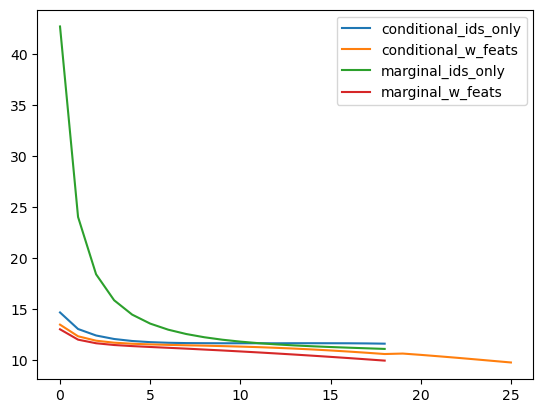

In [8]:
conditional_ids_only_train_loss = np.load('outputs/conditional_ids_only/train_loss_per_epoch.npy')[1:]
conditional_w_feats_loss = np.load('outputs/conditional_w_feats/train_loss_per_epoch.npy')[1:]
marginal_ids_only_train_loss = np.load('outputs/marginal_ids_only/train_loss_per_epoch.npy')[1:]
marginal_w_feats_loss = np.load('outputs/marginal_w_feats/train_loss_per_epoch.npy')[1:]

plt.plot(conditional_ids_only_train_loss, label='conditional_ids_only')
plt.plot(conditional_w_feats_loss, label='conditional_w_feats')
plt.plot(marginal_ids_only_train_loss, label='marginal_ids_only')
plt.plot(marginal_w_feats_loss, label='marginal_w_feats')
plt.legend()
plt.show()

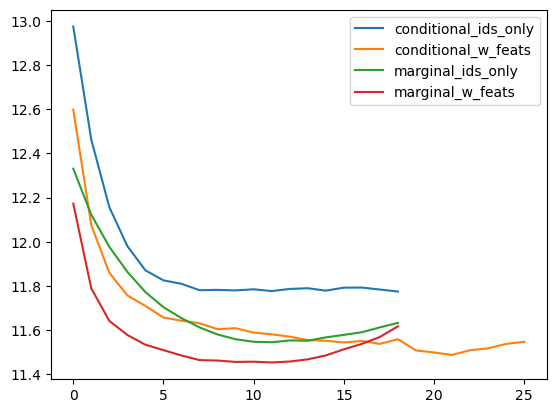

In [9]:
conditional_ids_only_loss = np.load('outputs/conditional_ids_only/test_loss_per_epoch.npy')[1:]
conditional_w_feats_loss = np.load('outputs/conditional_w_feats/test_loss_per_epoch.npy')[1:]
marginal_ids_only_loss = np.load('outputs/marginal_ids_only/test_loss_per_epoch.npy')[1:]
marginal_w_feats_loss = np.load('outputs/marginal_w_feats/test_loss_per_epoch.npy')[1:]

plt.plot(conditional_ids_only_loss, label='conditional_ids_only')
plt.plot(conditional_w_feats_loss, label='conditional_w_feats')
plt.plot(marginal_ids_only_loss, label='marginal_ids_only')
plt.plot(marginal_w_feats_loss, label='marginal_w_feats')
plt.legend()
plt.show()

In [10]:
true_marginal_ids_only_loss = np.load('outputs/true_marginal_ids_only/test_loss_per_epoch.npy')
true_marginal_w_feats_loss = np.load('outputs/true_marginal_w_feats/test_loss_per_epoch.npy')
fake_marginal_ids_only_loss = np.load('outputs/marginal_ids_only/test_loss_per_epoch.npy')
fake_marginal_w_feats_loss = np.load('outputs/marginal_w_feats/test_loss_per_epoch.npy')
conditional_ids_only_loss = np.load('outputs/conditional_ids_only/test_loss_per_epoch.npy')
conditional_w_feats_loss = np.load('outputs/conditional_w_feats/test_loss_per_epoch.npy')

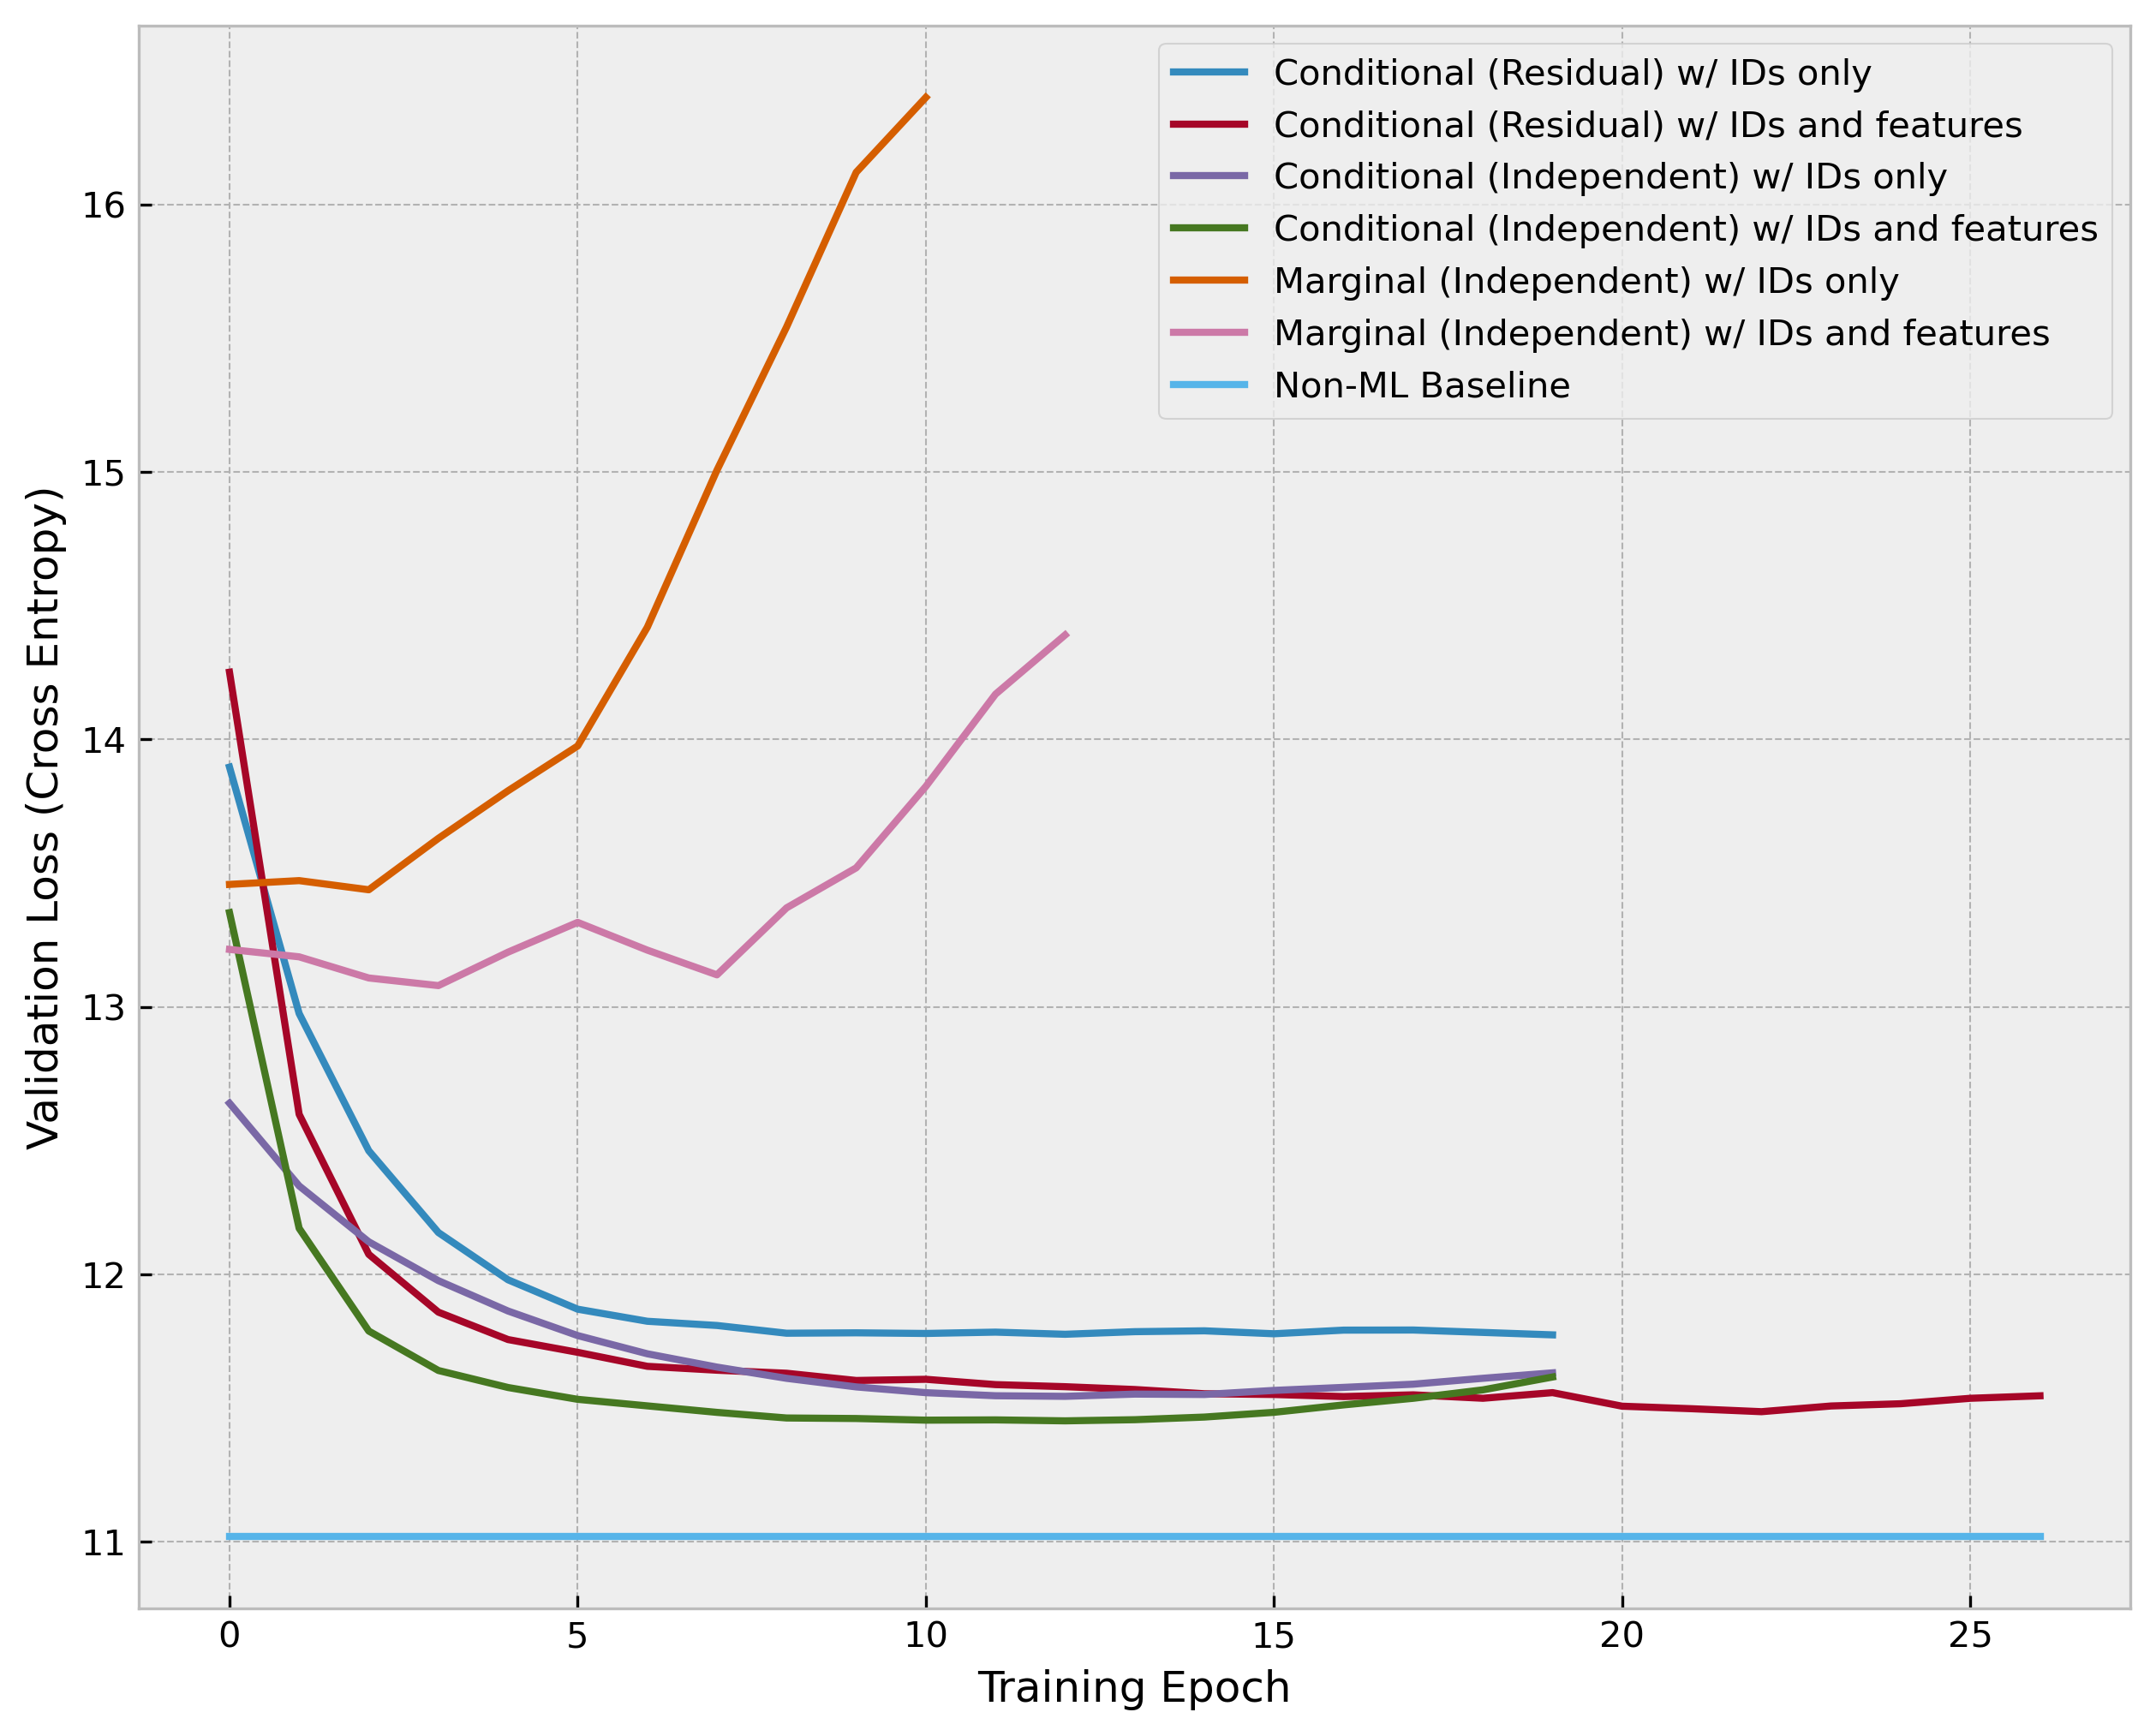

In [11]:
plt.style.use('bmh')
plt.figure(figsize=(10, 8), dpi=300)
plt.plot(conditional_ids_only_loss, label='Conditional (Residual) w/ IDs only')
plt.plot(conditional_w_feats_loss, label='Conditional (Residual) w/ IDs and features')
plt.plot(fake_marginal_ids_only_loss, label='Conditional (Independent) w/ IDs only')
plt.plot(fake_marginal_w_feats_loss, label='Conditional (Independent) w/ IDs and features')
plt.plot(true_marginal_ids_only_loss, label='Marginal (Independent) w/ IDs only')
plt.plot(true_marginal_w_feats_loss, label='Marginal (Independent) w/ IDs and features')
plt.plot([11.021]*27, label='Non-ML Baseline')
plt.xlabel('Training Epoch')
plt.ylabel('Validation Loss (Cross Entropy)')
plt.legend()
plt.savefig('losses.png')
plt.show()

In [12]:
print("min true_marginal_ids_only_loss:", np.min(true_marginal_ids_only_loss))
print("min true_marginal_w_feats_loss:", np.min(true_marginal_w_feats_loss))
print("min fake_marginal_ids_only_loss:", np.min(fake_marginal_ids_only_loss))
print("min fake_marginal_w_feats_loss:", np.min(fake_marginal_w_feats_loss))
print("min conditional_ids_only_loss:", np.min(conditional_ids_only_loss))
print("min conditional_w_feats_loss:", np.min(conditional_w_feats_loss))

min true_marginal_ids_only_loss: 13.438200062718884
min true_marginal_w_feats_loss: 13.07986281658041
min fake_marginal_ids_only_loss: 11.5440472323319
min fake_marginal_w_feats_loss: 11.452449190205542
min conditional_ids_only_loss: 11.773964742134357
min conditional_w_feats_loss: 11.486711238992624


# Simple Dataset Testing

In [1]:
from torch.utils.data import DataLoader
from dataset.taobao_simple_dataset import TaobaoDataset

In [ ]:
dataset = TaobaoDataset(
    data_dir = "data", 
    mode = "test",
    augmented = True,
    user_features = ["user"], # "gender", "age", "shopping", "occupation"],
    ad_features = ["cate", "brand", "customer", "campaign"],
)
len(dataset)

In [24]:
{feat: dim for feat, dim in zip(dataset.user_feats, dataset.input_dims)}

{'user': 490164}

In [25]:
{feat: dim for feat, dim in zip(dataset.ad_feats, dataset.output_dims)}

{'cate': 12354, 'brand': 406061, 'customer': 235134, 'campaign': 384463}

In [ ]:
for user_data, ads_features, ads_masks, timestamps, interactions in DataLoader(dataset, batch_size=4, shuffle=True):
    print("User Data:", user_data.shape)
    print(user_data)
    print("Ads Features:", ads_features.shape)
    print(ads_features)
    print("Ads Masks:", len(ads_masks))
    for feat, mask in zip(dataset.ad_feats[1:], ads_masks):
        print(f"{feat.capitalize()} Mask:", mask.shape)
        print(mask)
        print((~mask).sum(dim=1))
    print("Timestamps:", timestamps.shape)
    print(timestamps)
    print("Interactions:", interactions.shape)
    print(interactions)
    break

# Sequence Dataset Testing

In [1]:
from dataset.taobao_behavior_sequences import TaobaoSequenceDataset

In [2]:
dataset = TaobaoSequenceDataset(
    data_dir="data",
    is_train=False,
    augmented=False,
    user_features=["user"],
    ad_features=["adgroup", "cate", "brand", "customer", "campaign"]
)
len(dataset)

296391

In [3]:
print("Users:", dataset.n_users)
print("Num Ads:", dataset.n_ads)
print("Num Cates:", dataset.n_cates)
print("Num Brands:", dataset.n_brands)

Users: 490164
Num Ads: 734712
Num Cates: 12354
Num Brands: 406061


In [6]:
dataset.get_index(size=3000)

AdBatch(adgroup_id=tensor([433511, 309115, 548785,  ..., 627002, 518342,  61046],
       dtype=torch.int32), cate_id=tensor([3921, 4114, 5742,  ..., 7940, 6759, 5637], dtype=torch.int32), brand_id=tensor([262383, 391764,  41591,  ..., 136749,     -1, 353124],
       dtype=torch.int32), customer_id=tensor([212968, 214220,  19268,  ..., 226835,  47389,  72632],
       dtype=torch.int32), campaign_id=tensor([332692, 245312,  69878,  ..., 347529, 360763,   1368],
       dtype=torch.int32), rel_ad_freqs=array([7.1868089e-07, 3.9200773e-07, 6.5334625e-08, ..., 8.4935010e-07,
       6.5334625e-08, 6.5334625e-08], dtype=float32))

In [ ]:
dataset[3:6]